# HW2B: Neural Machine Translation

In this project, you will build a neural machine translation system using modern techniques for sequence-to-sequence modeling. You will first implement a baseline encoder-decoder architecture, then improve upon the baseline by adding an attention mechanism. The end result will be a fully functional translation system capable of translating simple German sentences into English.

## Setup

First we install and import the required dependencies. These include:
* `torch` for modeling and training
* `torchtext` for data collection
* `sentencepiece` for subword tokenization
* `sacrebleu` for BLEU score evaluation

In [1]:
# # Some of the functions below require an older version of torchtext than the default one Kaggle gives you.
# # IMPORTANT: Make sure that Internet is turned on!!! (Notebook options in the bar on the right)
# # IMPORTANT: If you're not already using Kaggle, we STRONGLY recommend you switch to Kaggle for hw1b in particular,
# # because copying our notebook will pin you to a Python version that lets you install the right version of torchtext.
# # On Colab you will have to downgrade your Python to e.g., 3.7 to do the below pip install, which is a pain to do.
# !pip install torchtext==0.8.1
# exit()

In [2]:
# %%capture
# !pip install --upgrade sacrebleu sentencepiece

# Standard library imports
import json
import math
import random
import pdb

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import sacrebleu
import sentencepiece
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import tqdm.notebook


Before proceeding, let's verify that we're connected to a GPU runtime and that `torch` can detect the GPU.
We'll define a variable `device` here to use throughout the code so that we can easily change to run on CPU for debugging.

In [3]:
assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Data

The data for this assignment comes from the [Multi30K dataset](https://arxiv.org/abs/1605.00459), which contains English and German captions for images from Flickr. We can download and unpack it using `torchtext`. We use the Multi30K dataset because it is simpler than standard translation benchmark datasets and allows for models to be trained and evaluated in a matter of minutes rather than days.

We will be translating from German to English in this assignment, but the same techniques apply equally well to any language pair.



In [4]:
import torchtext
from torchtext.datasets import Multi30k

Multi30k.urls = [
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"
]

extensions = [".de", ".en"]
source_field = torchtext.data.Field(tokenize=lambda x: x)
target_field = torchtext.data.Field(tokenize=lambda x: x)
training_data, validation_data, test_data = torchtext.datasets.Multi30k.splits(
    extensions, [source_field, target_field], root="./", test="test")

/home/slee/.conda/envs/cs288/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/slee/.conda/envs/cs288/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


Now that we have the data, let's see how large each split is and look at a few examples.


In [5]:
print("Number of training examples:", len(training_data))
print("Number of validation examples:", len(validation_data))
print("Number of test examples:", len(test_data))
print()

for example in training_data[:10]:
  print(example.src)
  print(example.trg)
  print()

Number of training examples: 29000
Number of validation examples: 1014
Number of test examples: 1000

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
Two young, White males are outside near many bushes.

Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
Several men in hard hats are operating a giant pulley system.

Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
A little girl climbing into a wooden playhouse.

Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.
A man in a blue shirt is standing on a ladder cleaning a window.

Zwei Männer stehen am Herd und bereiten Essen zu.
Two men are at the stove preparing food.

Ein Mann in grün hält eine Gitarre, während der andere Mann sein Hemd ansieht.
A man in green holds a guitar while the other man observes his shirt.

Ein Mann lächelt einen ausgestopften Löwen an.
A man is smiling at a stuffed lion

Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entla

## Vocabulary

We can use `sentencepiece` to create a joint German-English subword vocabulary from the training corpus. Because the number of training examples is small, we choose a smaller vocabulary size than would be used for large-scale NMT.

In [6]:
args = {
    "pad_id": 0,
    "bos_id": 1,
    "eos_id": 2,
    "unk_id": 3,
    "input": "multi30k/train.de,multi30k/train.en",
    "vocab_size": 8000,
    "model_prefix": "multi30k",
}
combined_args = " ".join(
    "--{}={}".format(key, value) for key, value in args.items())
sentencepiece.SentencePieceTrainer.Train(combined_args)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --input=multi30k/train.de,multi30k/train.en --vocab_size=8000 --model_prefix=multi30k
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: multi30k/train.de
  input: multi30k/train.en
  input_format: 
  model_prefix: multi30k
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_

This creates two files: `multi30k.model` and `multi30k.vocab`. The first is a binary file containing the relevant data for the vocabulary. The second is a human-readable listing of each subword and its associated score.

We can preview the contents of the vocabulary by looking at the first few rows from the human-readable file.

In [7]:
!head -n 30 multi30k.vocab

<pad>	0
<s>	0
</s>	0
<unk>	0
.	-2.72718
▁a	-3.21357
▁in	-3.43973
m	-3.78503
▁eine	-3.82141
▁A	-3.86856
s	-4.06457
▁Ein	-4.11399
,	-4.20405
▁the	-4.35217
▁und	-4.5704
▁mit	-4.57911
▁auf	-4.58144
▁on	-4.65674
n	-4.67038
▁Mann	-4.70521
▁is	-4.73988
▁man	-4.75331
▁and	-4.76404
▁	-4.76512
ing	-4.8072
▁of	-4.83344
▁einer	-4.86421
▁with	-4.93426
▁Eine	-4.98902
▁ein	-5.126


As we can see, the vocabulary consists of four special tokens (`<pad>` for padding, `<s>` for beginning of sentence (BOS), `</s>` for end of sentence (EOS), `<unk>` for unknown) and a mixture of German and English words and subwords. In order to ensure reversability, word boundaries are encoded with a special unicode character "▁" (U+2581).

To use the vocabulary, we first need to load it from the binary file produced above.

In [8]:
vocab = sentencepiece.SentencePieceProcessor()
vocab.Load("multi30k.model")

True

The vocabulary object includes a number of methods for working with full sequences or individual pieces. We explore the most relevant ones below. A complete interface can be found on [GitHub](https://github.com/google/sentencepiece/tree/master/python#usage) for reference.

In [9]:
print("Vocabulary size:", vocab.GetPieceSize())
print()

for example in training_data[:3]:
  sentence = example.trg
  pieces = vocab.EncodeAsPieces(sentence)
  indices = vocab.EncodeAsIds(sentence)
  print(sentence)
  print(pieces)
  print(vocab.DecodePieces(pieces))
  print(indices)
  print(vocab.DecodeIds(indices))
  print()

piece = vocab.EncodeAsPieces("the")[0]
index = vocab.PieceToId(piece)
print(piece)
print(index)
print(vocab.IdToPiece(index))

Vocabulary size: 8000

Two young, White males are outside near many bushes.
['▁Two', '▁young', ',', '▁White', '▁males', '▁are', '▁outside', '▁near', '▁many', '▁bushes', '.']
Two young, White males are outside near many bushes.
[42, 54, 12, 2889, 2225, 36, 127, 173, 815, 3513, 4]
Two young, White males are outside near many bushes.

Several men in hard hats are operating a giant pulley system.
['▁Se', 'veral', '▁men', '▁in', '▁hard', '▁hats', '▁are', '▁operating', '▁a', '▁g', 'iant', '▁pull', 'e', 'y', '▁s', 'y', 'ste', 'm', '.']
Several men in hard hats are operating a giant pulley system.
[298, 240, 73, 6, 712, 730, 36, 3106, 5, 631, 1679, 583, 32, 96, 552, 96, 1076, 7, 4]
Several men in hard hats are operating a giant pulley system.

A little girl climbing into a wooden playhouse.
['▁A', '▁little', '▁girl', '▁climbing', '▁in', 'to', '▁a', '▁wooden', '▁play', 'house', '.']
A little girl climbing into a wooden playhouse.
[9, 132, 66, 500, 6, 112, 5, 542, 245, 4599, 4]
A little girl cli

We define some constants here for the first three special tokens that you may find useful in the following sections.

In [10]:
pad_id = vocab.PieceToId("<pad>")
bos_id = vocab.PieceToId("<s>")
eos_id = vocab.PieceToId("</s>")

Note that these tokens will be stripped from the output when converting from word pieces to text. This may be helpful when implementing greedy search and beam search.

In [11]:
sentence = training_data[0].trg
indices = vocab.EncodeAsIds(sentence)
indices_augmented = [bos_id] + indices + [eos_id, pad_id, pad_id, pad_id]
print(vocab.DecodeIds(indices))
print(vocab.DecodeIds(indices_augmented))
print(vocab.DecodeIds(indices) == vocab.DecodeIds(indices_augmented))

Two young, White males are outside near many bushes.
Two young, White males are outside near many bushes.
True


## Baseline sequence-to-sequence model

With our data and vocabulary loaded, we're now ready to build a baseline sequence-to-sequence model.  Later on we'll add an attention mechanism to the model.

Let's begin by defining a batch iterator for the training data. Given a dataset and a batch size, it will iterate over the dataset and yield pairs of tensors containing the subword indices for the source and target sentences in the batch, respectively.  Fill in `make_batch` below.

In [12]:
VAL_BATCHSIZE = 2

In [13]:
def make_batch(sentences):
  """Convert a list of sentences into a batch of subword indices.

  Args:
    sentences: A list of sentences, each of which is a string.

  Returns:
    A LongTensor of size (max_sequence_length, batch_size) containing the
    subword indices for the sentences, where max_sequence_length is the length
    of the longest sentence as encoded by the subword vocabulary and batch_size
    is the number of sentences in the batch. A beginning-of-sentence token
    should be included before each sequence, and an end-of-sentence token should
    be included after each sequence. Empty slots at the end of shorter sequences
    should be filled with padding tokens. The tensor should be located on the
    device defined at the beginning of the notebook.
  """

  # Implementation tip: You can use the nn.utils.rnn.pad_sequence utility
  # function to combine a list of variable-length sequences with padding.

  # YOUR CODE HERE
  # BEGIN SOLUTION
  return nn.utils.rnn.pad_sequence([torch.tensor([bos_id] + vocab.EncodeAsIds(sentence) + [eos_id],dtype=torch.int64) for sentence in sentences],padding_value=pad_id)
  
  # END SOLUTION

def make_batch_iterator(dataset, batch_size, shuffle=False):
  """Make a batch iterator that yields source-target pairs.

  Args:
    dataset: A torchtext dataset object.
    batch_size: An integer batch size.
    shuffle: A boolean indicating whether to shuffle the examples.

  Yields:
    Pairs of tensors constructed by calling the make_batch function on the
    source and target sentences in the current group of examples. The max
    sequence length can differ between the source and target tensor, but the
    batch size will be the same. The final batch may be smaller than the given
    batch size.
  """

  examples = list(dataset)
  if shuffle:
    random.shuffle(examples)

  for start_index in range(0, len(examples), batch_size):
    example_batch = examples[start_index:start_index + batch_size]
    source_sentences = [example.src for example in example_batch]
    target_sentences = [example.trg for example in example_batch]
    yield make_batch(source_sentences), make_batch(target_sentences)

test_batch = make_batch(["a test input", "a longer input than the first"])
print("Example batch tensor:")
print(test_batch)
assert test_batch.shape[1] == 2
assert test_batch[0, 0] == bos_id
assert test_batch[0, 1] == bos_id
assert test_batch[-1, 0] == pad_id
assert test_batch[-1, 1] == eos_id

Example batch tensor:
tensor([[   1,    1],
        [   5,    5],
        [3966,  354],
        [   6,   60],
        [ 236,    6],
        [ 698,  236],
        [   2,  698],
        [   0, 5285],
        [   0,   13],
        [   0, 3759],
        [   0,    2]])


Now we will define the model itself. It should consist of a bidirectional LSTM encoder that encodes the input sentence into a fixed-size representation, and an LSTM decoder that uses this representation to produce the output sentence.

In [14]:
class Seq2seqBaseline(nn.Module):
  def __init__(self):
    super().__init__()

    # Initialize your model's parameters here. To get started, we suggest
    # setting all embedding and hidden dimensions to 256, using encoder and
    # decoder LSTMs with 2 layers, and using a dropout rate of 0.5.

    # Implementation tip: To create a bidirectional LSTM, you don't need to
    # create two LSTM networks. Instead use nn.LSTM(..., bidirectional=True).

    # YOUR CODE HERE

    # BEGIN SOLUTION
    self.v2=True # this version does not use weight tying for linear layer
    self.embedding_dim,self.hidden_dim,self.num_layers,self.bidirectional=256,256,2,True
    self.vocab_size = vocab.GetPieceSize()
    if self.bidirectional:
      self.D = 2
    else:
      self.D = 1
    self.encoderLSTM = nn.LSTM(self.embedding_dim,self.hidden_dim,num_layers=self.num_layers,bidirectional=self.bidirectional,dropout=0.5)     
    self.decoderLSTM = nn.LSTM(self.embedding_dim,self.hidden_dim,num_layers=self.num_layers,bidirectional=False,dropout=0.5)
    if self.v2:
      self.hidden2vocab = nn.Linear(self.hidden_dim, self.vocab_size)
      self.embedding = nn.Embedding(num_embeddings=self.vocab_size ,embedding_dim=self.embedding_dim)
    else:
      self.hidden2embedding = nn.Linear(self.hidden_dim, self.embedding_dim) 
      self.embedding2vocab = nn.Linear(self.embedding_dim,self.vocab_size) # apply weight tying as HW1
    # END SOLUTION

  def encode(self, source):
    """Encode the source batch using a bidirectional LSTM encoder.

    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for the source sentences.

    Returns:
      A tuple with three elements:
        encoder_output: The output of the bidirectional LSTM with shape
          (max_source_sequence_length, batch_size, 2 * hidden_size).
        encoder_mask: A boolean tensor with shape (max_source_sequence_length,
          batch_size) indicating which encoder outputs correspond to padding
          tokens. Its elements should be True at positions corresponding to
          padding tokens and False elsewhere.
        encoder_hidden: The final hidden states of the bidirectional LSTM (after
          a suitable projection) that will be used to initialize the decoder.
          This should be a pair of tensors (h_n, c_n), each with shape
          (num_layers, batch_size, hidden_size). Note that the hidden state
          returned by the LSTM cannot be used directly. Its initial dimension is
          twice the required size because it contains state from two directions.

    The first two return values are not required for the baseline model and will
    only be used later in the attention model. If desired, they can be replaced
    with None for the initial implementation.
    """

    # Implementation tip: consider using packed sequences to more easily work
    # with the variable-length sequences represented by the source tensor.
    # See https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.PackedSequence.

    # Implementation tip: there are many simple ways to combine the forward
    # and backward portions of the final hidden state, e.g. addition, averaging,
    # or a linear transformation of the appropriate size. Any of these
    # should let you reach the required performance.

    # Compute a tensor containing the length of each source sequence.
    lengths = torch.sum(source != pad_id, axis=0)

    # YOUR CODE HERE

    # BEGIN SOLUTION
    self.batchsize = source.size()[-1]
    encoder_mask = torch.eq(source, pad_id) # note this is not cuda-ed
    # packed_input = nn.utils.rnn.pack_padded_sequence(input=source.cuda(), lengths=lengths, batch_first=False, enforce_sorted=False) # note it would be sorted therefore to different order
    # if self.v2:
    #   input1 = self.embedding(packed_input.data)#F.embedding(source.long().cuda())#self.vocab2embedding(source.long().cuda())
    # else:
    #   input1 = F.embedding(packed_input.data, self.embedding2vocab.weight)
    if self.v2:
      input1 = self.embedding(source.to(self.encoderLSTM.all_weights[0][0].device))#F.embedding(source.long().cuda())#self.vocab2embedding(source.long().cuda())
    else:
      input1 = F.embedding(source.to(self.encoderLSTM.all_weights[0][0].device), self.embedding2vocab.weight)
    # print("after embdding",input1.size())
    packed_input = nn.utils.rnn.pack_padded_sequence(input=input1, lengths=lengths, batch_first=False, enforce_sorted=False) # note it would be sorted therefore to different order
    
    hidden = (torch.zeros(self.D * self.num_layers, self.batchsize, self.hidden_dim).to(self.encoderLSTM.all_weights[0][0].device),torch.zeros(self.D * self.num_layers, self.batchsize, self.hidden_dim).to(self.encoderLSTM.all_weights[0][0].device)) #initialize as 0s
    # print(packed_input.data.size())
    # print("input1,inithidden",packed_input.data.size(),hidden[0].size())
    encoder_output, encoder_hidden = self.encoderLSTM(packed_input,hidden)

    # print(encoder_hidden[0].size())
    # print(encoder_output.size())
    unpacked_output = nn.utils.rnn.pad_packed_sequence(sequence=encoder_output, batch_first=False) # note it would be sorted therefore to different order
    # print(unpacked_output[0].size())

    # forward_output, backward_output = torch.split(encoder_hidden, split_size_or_sections=2, dim=2)
    # print(forward_output.size(),backward_output.size())

    h_n_added = encoder_hidden[0].view(self.num_layers, self.D, self.batchsize, self.hidden_dim)[:, 0, :, :] + encoder_hidden[0].view(self.num_layers, self.D, self.batchsize, self.hidden_dim)[:, 1, :, :]
    c_n_added = encoder_hidden[1].view(self.num_layers, self.D, self.batchsize, self.hidden_dim)[:, 0, :, :] + encoder_hidden[1].view(self.num_layers, self.D, self.batchsize, self.hidden_dim)[:, 1, :, :]


    # h_n, c_n = encoder_hidden
    # # Split h_n into forward and backward components
    # forward_hn = h_n.view(self.num_layers, self.D, self.batchsize, self.hidden_dim)[:, 0, :, :]
    # backward_hn = h_n.view(self.num_layers, self.D, self.batchsize, self.hidden_dim)[:, 1, :, :]
    # # print(h_n.size(),forward_hn.size(),backward_hn.size())

    # # Split c_n into forward and backward components
    # forward_cn = c_n.view(self.num_layers, self.D, self.batchsize, self.hidden_dim)[:, 0, :, :]
    # backward_cn = c_n.view(self.num_layers, self.D, self.batchsize, self.hidden_dim)[:, 1, :, :]
    # # print(c_n.size(),forward_cn.size(),backward_cn.size())

    # h_n_added = forward_hn + backward_hn
    # c_n_added = forward_cn + backward_cn
    

    return unpacked_output[0], encoder_mask.to(self.encoderLSTM.all_weights[0][0].device), (h_n_added,c_n_added)
  
    # END SOLUTION

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask,packedsequence=False):
    """Run the decoder LSTM starting from an initial hidden state.

    The third and fourth arguments are not used in the baseline model, but are
    included for compatibility with the attention model in the next section.

    Args:
      decoder_input: An integer tensor with shape (max_decoder_sequence_length,
        batch_size) containing the subword indices for the decoder input. During
        evaluation, where decoding proceeds one step at a time, the initial
        dimension should be 1.
      initial_hidden: A pair of tensors (h_0, c_0) representing the initial
        state of the decoder, each with shape (num_layers, batch_size,
        hidden_size).
      encoder_output: The output of the encoder with shape
        (max_source_sequence_length, batch_size, 2 * hidden_size).
      encoder_mask: The output mask from the encoder with shape
        (max_source_sequence_length, batch_size). Encoder outputs at positions
        with a True value correspond to padding tokens and should be ignored.

    Returns:
      A tuple with three elements:
        logits: A tensor with shape (max_decoder_sequence_length, batch_size,
          vocab_size) containing unnormalized scores for the next-word
          predictions at each position.
        decoder_hidden: A pair of tensors (h_n, c_n) with the same shape as
          initial_hidden representing the updated decoder state after processing
          the decoder input.
        attention_weights: This will be implemented later in the attention
          model, but in order to maintain compatible type signatures, we also
          include it here. This can be None or any other placeholder value.
    """

    # These arguments are not used in the baseline model.
    del encoder_output
    del encoder_mask

    # YOUR CODE HERE

    # BEGIN SOLUTION
    # assert self.batchsize == decoder_input.size()[-1], print("Error, decoder batch size is different from encoder batch size")
    lengths = torch.sum(decoder_input != pad_id, axis=0)
    # print(lengths)

    if self.v2:
      if packedsequence:
        decoder_output, decoder_hidden = self.decoderLSTM(nn.utils.rnn.pack_padded_sequence(input=self.embedding(decoder_input.to(self.decoderLSTM.all_weights[0][0].device)), lengths=lengths, batch_first=False, enforce_sorted=False),initial_hidden)
        unpacked_output = nn.utils.rnn.pad_packed_sequence(sequence=decoder_output, batch_first=False)
      else:
        decoder_output, decoder_hidden = self.decoderLSTM(self.embedding(decoder_input.to(self.decoderLSTM.all_weights[0][0].device)),initial_hidden)
        unpacked_output = [decoder_output]
    else:
      decoder_output, decoder_hidden = self.decoderLSTM(nn.utils.rnn.pack_padded_sequence(input=F.embedding(decoder_input.to(self.decoderLSTM.all_weights[0][0].device), self.embedding2vocab.weight), lengths=lengths, batch_first=False, enforce_sorted=False),initial_hidden)
      unpacked_output = nn.utils.rnn.pad_packed_sequence(sequence=decoder_output, batch_first=False)

    # print(unpacked_output[0].size())
    # decoder_output size is L,N,hidden_dim
    if self.v2:
      logits = self.hidden2vocab(unpacked_output[0])
    else:
      logits = self.hidden2embedding(unpacked_output[0])
      logits = self.embedding2vocab(logits)
    # print(logits.size())
    return logits.cpu(), decoder_hidden, None
    # END SOLUTION

  def compute_loss(self, source, target):
    """Run the model on the source and compute the loss on the target.

    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for the source sentences.
      target: An integer tensor with shape (max_target_sequence_length,
        batch_size) containing subword indices for the target sentences.

    Returns:
      A scalar float tensor representing cross-entropy loss on the current batch.
    """

    # Implementation tip: don't feed the target tensor directly to the decoder.
    # To see why, note that for a target sequence like <s> A B C </s>, you would
    # want to run the decoder on the prefix <s> A B C and have it predict the
    # suffix A B C </s>.

    # YOUR CODE HERE

    # BEGIN SOLUTION
    encoder_output, encoder_mask, encoder_hidden = self.encode(source)
    decoder_input, decoder_target = target[:-1], target[1:]
    logits, decoder_hidden, attention_weights = self.decode(decoder_input, encoder_hidden, encoder_output, encoder_mask)
    # print(logits.size(), decoder_target.size())
    # print(logits.permute(1, 2, 0).size(), decoder_target.permute(1, 0).size())
    return F.cross_entropy(logits.permute(1, 2, 0), decoder_target.permute(1, 0), ignore_index=pad_id, #reduction="sum"
          )
 
    # losses=[]
    # for idx_readupto in range(1,len(target)):
    #   decoder_input = target[idx_readupto-1:idx_readupto] # this would give a tensor of size 1,batch_size
    #   if idx_readupto==1:
    #     logits, decoder_hidden, attention_weights = self.decode(decoder_input, encoder_hidden, encoder_output, encoder_mask)
    #   else:
    #     logits, decoder_hidden, attention_weights = self.decode(decoder_input, decoder_hidden, encoder_output, encoder_mask)
    #   loss = F.cross_entropy(logits[-1].cuda(),target[idx_readupto].cuda(),
    #       ignore_index=pad_id,#reduction="sum"
    #       )
    #   losses.append(loss)
    # return torch.mean(torch.stack(losses))
    # END SOLUTION

We define the following functions for training.  This code will run as provided, but you are welcome to modify the training loop to adjust the optimizer settings, add learning rate decay, etc.


In [15]:
def train(model, num_epochs, batch_size, model_file):
  """Train the model and save its best checkpoint.

  Model performance across epochs is evaluated using token-level accuracy on the
  validation set. The best checkpoint obtained during training will be stored on
  disk and loaded back into the model at the end of training.
  """
  optimizer = torch.optim.Adam(model.parameters())
  best_accuracy = 0.0
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(
        make_batch_iterator(training_data, batch_size, shuffle=True),
        desc="epoch {}".format(epoch + 1),
        unit="batch",
        total=math.ceil(len(training_data) / batch_size)) as batch_iterator:
      model.train()
      total_loss = 0.0
      for i, (source, target) in enumerate(batch_iterator, start=1):
        optimizer.zero_grad()
        loss = model.compute_loss(source, target) 
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        batch_iterator.set_postfix(mean_loss=total_loss / i)
      validation_perplexity, validation_accuracy = evaluate_next_token(
          model, validation_data) 
      batch_iterator.set_postfix(
          mean_loss=total_loss / i,
          validation_perplexity=validation_perplexity,
          validation_token_accuracy=validation_accuracy)
      if validation_accuracy > best_accuracy:
        print(
            "Obtained a new best validation accuracy of {:.2f}, saving model "
            "checkpoint to {}...".format(validation_accuracy, model_file))
        torch.save(model.state_dict(), model_file)
        best_accuracy = validation_accuracy
  print("Reloading best model checkpoint from {}...".format(model_file))
  model.load_state_dict(torch.load(model_file))

def evaluate_next_token(model, dataset, batch_size=64):# changed  this to not default to 64
  """Compute token-level perplexity and accuracy metrics.

  Note that the perplexity here is over subwords, not words.

  This function is used for validation set evaluation at the end of each epoch
  and should not be modified.
  """
  model.eval()
  total_cross_entropy = 0.0
  total_predictions = 0
  correct_predictions = 0
  with torch.no_grad():
    for source, target in make_batch_iterator(dataset, batch_size):
      encoder_output, encoder_mask, encoder_hidden = model.encode(source)
      decoder_input, decoder_target = target[:-1], target[1:]
      logits, decoder_hidden, attention_weights = model.decode(
          decoder_input, encoder_hidden, encoder_output, encoder_mask)
      total_cross_entropy += F.cross_entropy(
          logits.permute(1, 2, 0), decoder_target.permute(1, 0),
          ignore_index=pad_id, reduction="sum").item()
      total_predictions += (decoder_target != pad_id).sum().item()
      correct_predictions += (
          (decoder_target != pad_id) &
          (decoder_target == logits.argmax(2))).sum().item()
  perplexity = math.exp(total_cross_entropy / total_predictions)
  accuracy = 100 * correct_predictions / total_predictions
  return perplexity, accuracy

We can now train the baseline model.

Since we haven't yet defined a decoding method to output an entire string, we will measure performance for now by computing perplexity and the accuracy of predicting the next token given a gold prefix of the output. A correct implementation should get a validation token accuracy above 55%. The training code will automatically save the model with the highest validation accuracy and reload that checkpoint's parameters at the end of training.

In [16]:
# You are welcome to adjust these parameters based on your model implementation.
num_epochs = 10
batch_size = 16

baseline_model = Seq2seqBaseline().to(device)
train(baseline_model, num_epochs, batch_size, "baseline_model.pt")

training:   0%|          | 0/10 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 43.92, saving model checkpoint to baseline_model.pt...


epoch 2:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 47.83, saving model checkpoint to baseline_model.pt...


epoch 3:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 50.64, saving model checkpoint to baseline_model.pt...


epoch 4:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 52.56, saving model checkpoint to baseline_model.pt...


epoch 5:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 53.46, saving model checkpoint to baseline_model.pt...


epoch 6:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 54.51, saving model checkpoint to baseline_model.pt...


epoch 7:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 54.79, saving model checkpoint to baseline_model.pt...


epoch 8:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 55.16, saving model checkpoint to baseline_model.pt...


epoch 9:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 55.59, saving model checkpoint to baseline_model.pt...


epoch 10:   0%|          | 0/1813 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 55.82, saving model checkpoint to baseline_model.pt...
Reloading best model checkpoint from baseline_model.pt...


**Download your baseline model here.** Once you have a model you are happy with, you are encouraged to download it or save it to your Google Drive in case your session disconnects. The best baseline model has been saved to `baseline_model.pt` in the local filesystem. You will need a trained model while implementing inference below and to generate your final predictions. To download session files from Kaggle, please click the data tab on the right side of the screen and expand the `/kaggle/working` folder. You can do a similar process in Google drive.

For evaluation, we also need to be able to generate entire strings from the model. We'll first define a greedy inference procedure here. Later on, we'll implement beam search.

A correct implementation of greedy decoding should get above 20 BLEU on the validation set.

In [16]:
def predict_greedy(model, sentences, max_length=100,packedsequence=False):
  """Make predictions for the given inputs using greedy inference.

  Args:
    model: A sequence-to-sequence model.
    sentences: A list of input sentences, represented as strings.
    max_length: The maximum length at which to truncate outputs in order to
      avoid non-terminating inference.

  Returns:
    A list of predicted translations, represented as strings.
  """

  # Requirement: your implementation must be batched. This means that you should
  # make only one call to model.encode() at the start of the function, and make
  # only one call to model.decode() per inference step.

  # Implementation tip: once an EOS token has been generated, force the output
  # for that example to be padding tokens in all subsequent time steps by
  # adding a large positive number like 1e9 to the appropriate logits.

  # YOUR CODE HERE

  # BEGIN SOLUTION
  model.eval()
  with torch.no_grad():
    encoder_output, encoder_mask, encoder_hidden = model.encode(make_batch(sentences))
    # print(encoder_output.size(),encoder_hidden[0].size())
    decoder_input = torch.tensor([torch.tensor([bos_id],dtype=torch.int64) for sentence in sentences],dtype=torch.int64).unsqueeze(0) # initial input of start tokens <s>
    # print(initial_decoderinput.size())
    # print(encoder_output.size(),decoder_input.size(),decoder_input)
    if packedsequence:
      # This version is inefficient, feeds the whole decoder input and another one put and feeds the whole decoder input up to here again
      for seq_len_here in range(max_length-1):
        # print("decoderinput",decoder_input.size())
        logits, decoder_hidden, attention_weights = model.decode(decoder_input, encoder_hidden, encoder_output, encoder_mask,packedsequence=True) # Setting packedsequence True is default #gives     
  
        last_token_logits = logits[-1:, :, :]
        # print(seq_len_here,logits.size(),last_token_logits.size())
        # print("logits and last ",logits.size(),last_token_logits.size()) 
        if seq_len_here>0:# using end_mask we will add 1e9 to logits corresponding to pad_id, end_mask has batch positions where it ended
          # print(end_mask.unsqueeze(2).size())
          last_token_logits[:, :, pad_id:pad_id+1]+=end_mask.unsqueeze(2)*1e9
          # print(last_token_logits.size())
        next_token_greedy = last_token_logits.argmax(dim=2) # Greedy decoding from only the last word. Note logits will be (sequence_length, batch_size, vocab_size). -1 operation would give (1, batch_size, vocab_size) and then argmax will max over vocab_size giving torch tensor of size (1, batch_size)
        # print("last token pred",next_token_greedy.size())
        # get mask of where it already ended or just ended
        end_mask = (next_token_greedy == pad_id) | (next_token_greedy == eos_id)
        if end_mask.all(): # end before max_token is reached 
          break
        
        # print("end mask", end_mask.size())
        decoder_input = torch.cat((decoder_input, next_token_greedy), dim=0)
        # print("decoder input for next",decoder_input.size())
        # if seq_len_here>1:
        #   return 0
      list_of_sents = [vocab.DecodeIds(decoder_input[:, i].tolist()) for i in range(len(sentences))]
    else:
      # This version uses updated decoder_hidden so only takes one timestep of decoder input
      
      for seq_len_here in range(max_length-1):
        # print("decoderinput",decoder_input.size())
        if seq_len_here==0:
          logits, decoder_hidden, attention_weights = model.decode(decoder_input, encoder_hidden, encoder_output, encoder_mask)    # Setting this True will give RuntimeError: Length of all samples has to be greater than 0, but found an element in 'lengths' that is <= 0 
          last_token_logits = logits[-1:, :, :] # would be size one anyway here but...
          # print(logits.size(),last_token_logits.size())
          # we dont have end_mask yet, if something ended already we will calculate at the end of this iteration
        else:
          logits, decoder_hidden, attention_weights = model.decode(decoder_input, decoder_hidden, encoder_output, encoder_mask)
          last_token_logits = logits[-1:, :, :]
          last_token_logits[:, :, pad_id:pad_id+1]+=end_mask.unsqueeze(2)*1e9
        # print(seq_len_here,logits.size(),last_token_logits.size())
        next_token_greedy = last_token_logits.argmax(dim=2) # Greedy decoding from only the last word. Note logits will be (sequence_length, batch_size, vocab_size). -1 operation would give (1, batch_size, vocab_size) and then argmax will max over vocab_size giving torch tensor of size (1, batch_size)
        end_mask = (next_token_greedy == pad_id) | (next_token_greedy == eos_id)
        if end_mask.all(): # end before max_token is reached 
          break
        if seq_len_here==0:
          result = torch.cat((decoder_input, next_token_greedy), dim=0)
        else:
          result = torch.cat((result, next_token_greedy), dim=0)
          
        decoder_input = next_token_greedy#torch.cat((decoder_input, next_token_greedy), dim=0)

      list_of_sents = [vocab.DecodeIds(result[:, i].tolist()) for i in range(len(sentences))]
  

  return list_of_sents
  # END SOLUTION


def evaluate(model, dataset, batch_size=64, method="greedy"):
  assert method in {"greedy", "beam"}
  source_sentences = [example.src for example in dataset]
  target_sentences = [example.trg for example in dataset]
  model.eval()
  predictions = []
  with torch.no_grad():
    for start_index in range(0, len(source_sentences), batch_size):
      if method == "greedy":
        prediction_batch = predict_greedy(
            model, source_sentences[start_index:start_index + batch_size])
      else:
        prediction_batch = predict_beam(
            model, source_sentences[start_index:start_index + batch_size])
        prediction_batch = [candidates[0] for candidates in prediction_batch]
      predictions.extend(prediction_batch)
  return sacrebleu.corpus_bleu(predictions, [target_sentences]).score
  
def show_predictions(model, num_examples=4, include_beam=False):
  for example in validation_data[:num_examples]:
    print("Input:")
    print(" ", example.src)
    print("Target:")
    print(" ", example.trg)
    print("Greedy prediction:")
    print(" ", predict_greedy(model, [example.src])[0])
    if include_beam:
      print("Beam predictions:")
      for candidate in predict_beam(model, [example.src])[0]:
        print(" ", candidate)
    print()

In [22]:
baseline_model = Seq2seqBaseline().to(device)
baseline_model.load_state_dict(torch.load("baseline_model.pt"))

print("Baseline model validation BLEU using greedy search:",
      evaluate(baseline_model, validation_data))
      
print("Baseline model sample predictions:")
print()
show_predictions(baseline_model)

Baseline model validation BLEU using greedy search: 20.75284617238073
Baseline model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are laying on a tree stump.

Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man is sleeping in a green chair on a couch.

Input:
  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:
  A boy wearing headphones sits on a woman's shoulders.
Greedy prediction:
  A boy without a shirt sits on the steps of a woman.

Input:
  Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target:
  Two men setting up a blue ice fishing hut on an iced over lake
Greedy prediction:
  Two men are eating a blue object at a carnival game.



## Sequence-to-sequence model with attention

Next, we extend the baseline model to include an attention mechanism in the decoder. This circumvents the need to store all information about the source sentence in a fixed-size representation, and should substantially improve performance and convergence time.

Your implementation should use bilinear attention, where the attention distribution over the encoder outputs $e_1, \dots, e_n$ given a decoder LSTM output $d$ is obtained via a softmax of the dot products after a suitable projection to get them to the same size: $w_i \propto \exp ( d^\top W e_i )$. The unnormalized attention logits for encoder outputs corresponding to padding tokens should be offset with a large negative value to ensure that the corresponding attention weights are $0$.

After computing the attention distribution, take a weighted sum of the projected encoder outputs to obtain the attention context $c = \sum_i w_i We_i$, and add this to the decoder output $d$ to obtain the final representation to be passed to the vocabulary projection layer.

In [17]:
# from opt_einsum import contract
from opt_einsum_torch import einsum
class Seq2seqAttention(Seq2seqBaseline):
  def __init__(self):
    super().__init__()

    # Initialize any additional parameters needed for this model that are not
    # already included in the baseline model.

    # YOUR CODE HERE

    # BEGIN SOLUTION
    #Maybe I should initiate it as ones?? does zeros get updated
    # Create a learnable parameter from the concatenated identity matrix
    twoI = torch.cat((torch.eye(self.hidden_dim), torch.eye(self.hidden_dim)), dim=1)
    self.W = nn.Parameter(twoI, requires_grad=True).to('cuda:2') # hidden_dim x 2hidden_dim
    # self.cuda3='cuda:3'

    # self.v2=True # this version does not use weight tying for linear layer
    # self.embedding_dim,self.hidden_dim,self.num_layers,self.bidirectional=256,256,2,True
    # self.vocab_size = vocab.GetPieceSize()
    # if self.bidirectional:
    #   self.D = 2
    # else:
    #   self.D = 1
    # self.encoderLSTM = nn.LSTM(self.embedding_dim,self.hidden_dim,num_layers=self.num_layers,bidirectional=self.bidirectional,dropout=0.5)     
    # self.decoderLSTM = nn.LSTM(self.embedding_dim,self.hidden_dim,num_layers=self.num_layers,bidirectional=False,dropout=0.5)
    # if self.v2:
    #   self.hidden2vocab = nn.Linear(self.hidden_dim, self.vocab_size).to(self.cuda3)
    #   self.embedding = nn.Embedding(num_embeddings=self.vocab_size ,embedding_dim=self.embedding_dim)
    # else:
    #   self.hidden2embedding = nn.Linear(self.hidden_dim, self.embedding_dim) 
    #   self.embedding2vocab = nn.Linear(self.embedding_dim,self.vocab_size) # apply weight tying as HW1
    # # END SOLUTION



    # print(self.W.size())
    # END SOLUTION

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask, packedsequence=False):
    """Run the decoder LSTM starting from an initial hidden state.

    The third and fourth arguments are not used in the baseline model, but are
    included for compatibility with the attention model in the next section.

    Args:
      decoder_input: An integer tensor with shape (max_decoder_sequence_length,
        batch_size) containing the subword indices for the decoder input. During
        evaluation, where decoding proceeds one step at a time, the initial
        dimension should be 1.
      initial_hidden: A pair of tensors (h_0, c_0) representing the initial
        state of the decoder, each with shape (num_layers, batch_size,
        hidden_size).
      encoder_output: The output of the encoder with shape
        (max_source_sequence_length, batch_size, 2 * hidden_size).
      encoder_mask: The output mask from the encoder with shape
        (max_source_sequence_length, batch_size). Encoder outputs at positions
        with a True value correspond to padding tokens and should be ignored.

    Returns:
      A tuple with three elements:
        logits: A tensor with shape (max_decoder_sequence_length, batch_size,
          vocab_size) containing unnormalized scores for the next-word
          predictions at each position.
        decoder_hidden: A pair of tensors (h_n, c_n) with the same shape as
          initial_hidden representing the updated decoder state after processing
          the decoder input.
        attention_weights: A tensor with shape (max_decoder_sequence_length,
          batch_size, max_source_sequence_length) representing the normalized
          attention weights. This should sum to 1 along the last dimension.
    """

    # Implementation tip: use a large negative number like -1e9 instead of
    # float("-inf") when masking logits to avoid numerical issues.

    # Implementation tip: the function torch.einsum may be useful here.
    # See https://rockt.github.io/2018/04/30/einsum for a tutorial.

    # YOUR CODE HERE

    # BEGIN SOLUTION
    # assert self.batchsize == decoder_input.size()[-1], print("Error, decoder batch size is different from encoder batch size")
    self.batchsize_decoder=decoder_input.size()[1]
    lengths = torch.sum(decoder_input != pad_id, axis=0)
    # print(lengths)

    # if self.v2:
    #   input1 = self.embedding(decoder_input.cuda())#F.embedding(source.long().cuda())#self.vocab2embedding(source.long().cuda())
    # else:
    #   input1 = F.embedding(decoder_input.cuda(), self.embedding2vocab.weight)
    # # print("after embdding",input1.size())
    # packed_input = nn.utils.rnn.pack_padded_sequence(input=input1, lengths=lengths, batch_first=False, enforce_sorted=False) # note it would be sorted therefore to different order
    # decoder_output, decoder_hidden = self.decoderLSTM(packed_input,initial_hidden)
    # unpacked_output = nn.utils.rnn.pad_packed_sequence(sequence=decoder_output, batch_first=False)

    if self.v2:
      if packedsequence:
        decoder_output, decoder_hidden = self.decoderLSTM(nn.utils.rnn.pack_padded_sequence(input=self.embedding(decoder_input.to(self.decoderLSTM.all_weights[0][0].device)), lengths=lengths, batch_first=False, enforce_sorted=False),initial_hidden)
        unpacked_output = nn.utils.rnn.pad_packed_sequence(sequence=decoder_output, batch_first=False)
      else:
        decoder_output, decoder_hidden = self.decoderLSTM(self.embedding(decoder_input.to(self.decoderLSTM.all_weights[0][0].device)),initial_hidden)
        unpacked_output = [decoder_output]
    else:
      decoder_output, decoder_hidden = self.decoderLSTM(nn.utils.rnn.pack_padded_sequence(input=F.embedding(decoder_input.to(self.decoderLSTM.all_weights[0][0].device), self.embedding2vocab.weight), lengths=lengths, batch_first=False, enforce_sorted=False),initial_hidden)
      unpacked_output = nn.utils.rnn.pad_packed_sequence(sequence=decoder_output, batch_first=False)


    # # encoder output has dimension (L,N,2*hidden_dim) while decoder output (unpacked_output[0]) has (L,N, hidden_dim)
    # # for dot product, we need the same dimension
    # #add forward & backward components from encoder
    # encoder_forward_output, encoder_backward_output = torch.split(encoder_output, split_size_or_sections=encoder_output.size()[2]//2, dim=2)
    # encoder_output_added = torch.add(encoder_forward_output, encoder_backward_output)


    # Your implementation should use bilinear attention, where the attention distribution over the encoder outputs 
    # e_1, ..., e_n given a decoder LSTM output d is obtained via a softmax of the dot products after a suitable projection
    # to get them to the same size: w_i (prop) exp( dT W e_i ).
    # The unnormalized attention logits for encoder outputs corresponding to padding tokens should be offset with
    # a large negative value to ensure that the corresponding attention weights are 0.
    encoder_output = encoder_output.to(self.W.device)
    # unpacked_output[0] = unpacked_output[0].to(self.W.device)
  
    overtimesteps = []
    max_decoder_sequence_length = unpacked_output[0].size()[0]
    # print(max_decoder_sequence_length)
    # ones_sourcebatchsize = torch.ones(self.batchsize).cuda()
    # Duplicate the W N times along the new dimension
    # print(self.W.size(),ones_sourcebatchsize.size())





    # print("\n\n\n\n\nNEXT\n\n\n\n")

    # ### opt_einsum_torch does not retain gradients!!!
    # W = einsum('ij,k->kij', self.W, torch.ones(self.batchsize).to(self.W.device), cuda_device=self.W.device, cuda_mem_limit=0.9).to(self.W.device) # would this cause problem to gradient update ???
    # print("W",W.size(),W)
    # for timestep in range(max_decoder_sequence_length):
    #   dWe = einsum('nh,nhb,lnb->nl', unpacked_output[0][timestep].to(self.W.device), W, encoder_output, cuda_device=self.W.device, cuda_mem_limit=0.9).to(self.W.device) # size batchsize N x L encoder seq length
    #   if timestep==1:
    #     print("dWe",dWe.size(),dWe)
    #   dWe.masked_fill_(encoder_mask.permute(1, 0).to(self.W.device), # to get same size as N x L,
    #                     value=-1e9)
    #   dWe = F.softmax(dWe, dim=1)
    #   if timestep==1:
    #     print("dWe",dWe.size(),dWe)
    #   overtimesteps.append(dWe)

    # attention_weights = torch.stack(overtimesteps, dim=0)# (timesteps, N,L)
    # logits = torch.add(unpacked_output[0],einsum('tnl,nhb,lnb->tnh', attention_weights, W, encoder_output, cuda_device=self.W.device, cuda_mem_limit=0.9).to(self.decoderLSTM.all_weights[0][0].device))
    # print("logits",logits.size(),logits)
    # print("\n\n\n")


    # # original code, takes toooo much memory
    # WW = torch.einsum('ij,k->kij', self.W, torch.ones(self.batchsize).to(self.W.device)) # would this cause problem to gradient update ???

    # print("W",WW.size(),WW)
    # for timestep in range(max_decoder_sequence_length):
    #   dWe = torch.einsum('nh,nhb,lnb->nl', [unpacked_output[0][timestep].to(self.W.device), WW, encoder_output]) # size batchsize N x L encoder seq length
    #   if timestep==1:
    #     print("dWe",dWe.size(),dWe)
    #   dWe.masked_fill_(encoder_mask.permute(1, 0).to(self.W.device), # to get same size as N x L,
    #                     value=-1e9)
    #   dWe = F.softmax(dWe, dim=1)
    #   if timestep==1:
    #     print("dWe",dWe.size(),dWe)
    #   overtimesteps.append(dWe)

    # attention_weights = torch.stack(overtimesteps, dim=0)# (timesteps, N,L)
    # logits = torch.add(unpacked_output[0],torch.einsum('tnl,nhb,lnb->tnh', [attention_weights, WW, encoder_output]).to(self.decoderLSTM.all_weights[0][0].device))
    # print("logits",logits.size(),logits)
    # print("\n\n\n\n")


    # modified code for einsum
    # WW = torch.einsum('hb,n->nhb', self.W, torch.ones(self.batchsize).to(self.W.device)) # would this cause problem to gradient update ???
    WW = self.W.unsqueeze(0).expand(self.batchsize_decoder, -1, -1)# should use expand not einsum, einsum gives grad_fn ViewBackward while expand gives ExpandBackward 
    # print("W",WW.size(),WW)
    for timestep in range(max_decoder_sequence_length):
      #dWe = torch.einsum('nh,nhb,lnb->nl', [unpacked_output[0][timestep].to(self.W.device), WW, encoder_output]) # size batchsize N x L encoder seq length
      #method association 1
      dWe = torch.einsum('nh,nhb->nb', [unpacked_output[0][timestep].to(self.W.device), WW]) # size batchsize N x L encoder seq length
      dWe = torch.einsum('nb,lnb->ln', [dWe, encoder_output]) # size batchsize N x L encoder seq length
      dWe = torch.transpose(dWe,0,1) #nl
      # #method association 2
      # dWe = torch.einsum('nh,nhb,lnb->nl', [unpacked_output[0][timestep].to(self.W.device), WW, encoder_output]) # size batchsize N x L encoder seq length
      # dWe = torch.einsum('nh,nhb,lnb->nl', [unpacked_output[0][timestep].to(self.W.device), WW, encoder_output]) # size batchsize N x L encoder seq length
      
      # if timestep==1:
      #   print("dWe",dWe.size(),dWe)
      dWe.masked_fill_(encoder_mask.permute(1, 0).to(self.W.device), # to get same size as N x L,
                        value=-1e9)
      dWe = F.softmax(dWe, dim=1)
      # if timestep==1:
      #   print("dWe",dWe.size(),dWe)
      overtimesteps.append(dWe)

    attention_weights = torch.stack(overtimesteps, dim=0)# (timesteps, N,L)

    #logits = torch.add(unpacked_output[0],torch.einsum('tnl,nhb,lnb->tnh', [attention_weights, WW, encoder_output]).to(self.decoderLSTM.all_weights[0][0].device))
    logits = torch.einsum('lnb,nhb->lnh', [encoder_output,WW])
    logits = torch.einsum('tnl,lnh->tnh', [attention_weights, logits]).to(self.decoderLSTM.all_weights[0][0].device)
    logits = torch.add(unpacked_output[0],logits)
    
    # print("logits",logits.size(),logits)
    # print("\n\n\n\n")



    # W = torch.einsum('ij,k->kij', self.W, torch.ones(self.batchsize).to(self.W.device)) # would this cause problem to gradient update ???
    # # print("W",W.size()) #[batchsize, hiddendim, 2hiddendim])

    # for timestep in range(max_decoder_sequence_length):
    #   #print("here",unpacked_output[0][timestep].size()) # [batch_size x hidden_dimension]
    #   #print(unpacked_output[0][timestep])
    #   # d = unpacked_output[0][timestep]

    #   # dT = torch.einsum('ij->ji', [unpacked_output[0][timestep]])
    #   # print("dT",unpacked_output[0][timestep].size(),dT.size()) #[batchsize x 1 x hiddendim]
    #   # print(encoder_output.size()) # [seqlen,batch,2hiddendim]
    #   dWe = torch.einsum('nh,nhb,lnb->nl', [unpacked_output[0][timestep].to(self.W.device), W, encoder_output]) # size batchsize N x L encoder seq length
    #   # strange, these logits seem like all positive, maybe because I printed the first timestep?
    #   dWe.masked_fill_(encoder_mask.permute(1, 0).to(self.W.device), # to get same size as N x L,
    #                     value=-1e9)
    #   dWe = F.softmax(dWe, dim=1)
    #   # break
    #   overtimesteps.append(dWe)

    # attention_weights = torch.stack(overtimesteps, dim=0)# (timesteps, N,L)

    # # After computing the attention distribution, take a weighted sum of the projected encoder outputs 
    # # to obtain the attention context c = \sum_i w_i W e_i$, and add this to the decoder output d 
    # # to obtain the final representation to be passed to the vocabulary projection layer.


    # # w_i (timesteps, N,L)    W [N, H, 2H]) e_i [L (or 1), N, 2H]
    # # print(unpacked_output[0].size()) # (timesteps,N,hidden)
    # # print(unpacked_output[0].size())
    # # c = torch.einsum('tnl,nhb,lnb->tnh', [attention_weights, W, encoder_output])
    # # print(c.size())
    # logits = torch.add(unpacked_output[0],torch.einsum('tnl,nhb,lnb->tnh', [attention_weights, W, encoder_output]).to(self.decoderLSTM.all_weights[0][0].device))





    if self.v2:
      logits = self.hidden2vocab(logits)
    # else:
    #   logits = self.hidden2embedding(logits)
    #   logits = self.embedding2vocab(logits)
    # print(logits.size())

    return logits.cpu(), decoder_hidden, attention_weights.to(device)

    
    # END SOLUTION

In [20]:
# You are welcome to adjust these parameters based on your model implementation.
num_epochs = 10
batch_size = 32

attention_model = Seq2seqAttention().to('cuda:1')
train(attention_model, num_epochs, batch_size, "attention_model.pt")
# print("Attention model validation BLEU using greedy search:",
#       evaluate(attention_model, validation_data))


training:   0%|          | 0/10 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/907 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 53.54, saving model checkpoint to attention_model_einsumexp.pt...


epoch 2:   0%|          | 0/907 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 59.55, saving model checkpoint to attention_model_einsumexp.pt...


epoch 3:   0%|          | 0/907 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 61.47, saving model checkpoint to attention_model_einsumexp.pt...


epoch 4:   0%|          | 0/907 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 63.49, saving model checkpoint to attention_model_einsumexp.pt...


epoch 5:   0%|          | 0/907 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 64.32, saving model checkpoint to attention_model_einsumexp.pt...


epoch 6:   0%|          | 0/907 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 64.96, saving model checkpoint to attention_model_einsumexp.pt...


epoch 7:   0%|          | 0/907 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.43, saving model checkpoint to attention_model_einsumexp.pt...


epoch 8:   0%|          | 0/907 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.96, saving model checkpoint to attention_model_einsumexp.pt...


epoch 9:   0%|          | 0/907 [00:00<?, ?batch/s]

epoch 10:   0%|          | 0/907 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 66.25, saving model checkpoint to attention_model_einsumexp.pt...
Reloading best model checkpoint from attention_model_einsumexp.pt...


As before, we can train an attention model using the provided training code.

A correct implementation should get a validation token accuracy above 64 and a validation BLEU above 36 with greedy search.

**Download your attention model here.** Once you have a model you are happy with, you are encouraged to download it or save it to your Google Drive in case your session disconnects. The best attention model has been saved to `attention_model.pt` in the local filesystem. You will need a trained model while implementing beam search below and to generate your final predictions.


In [24]:
attention_model = Seq2seqAttention().to(device)
attention_model.load_state_dict(torch.load("attention_model.pt"))
print("Attention model validation BLEU using greedy search:",
      evaluate(attention_model, validation_data))
print()
print("Attention model sample predictions:")
print()
show_predictions(attention_model)


Attention model validation BLEU using greedy search: 37.06228439997626

Attention model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men loading cottalolenild.

Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man sleeps on a couch in a green room.

Input:
  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:
  A boy wearing headphones sits on a woman's shoulders.
Greedy prediction:
  A boy with earphones sits on the shoulders of a woman.

Input:
  Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target:
  Two men setting up a blue ice fishing hut on an iced over lake
Greedy prediction:
  Two men are building a blue ice cream ladder on a raild lake.



## Beam Search

Now it's time to implement beam search.

Similar to greedy search, beam search generates one token at a time. However, rather than keeping only the single best hypothesis, we instead keep the top $k$ candidates at each time step. This is accomplished by computing the set of next-token extensions for each item on the beam and finding the top $k$ across all candidates according to total log-probability.

Candidates that are finished should stay on the beam through the end of inference. The search process concludes once all $k$ items on the beam are complete.

With beam search, you should get an improvement of at least 0.5 BLEU over greedy search, and should reach above 21 BLEU without attention and above 37 BLEU with attention.

**Tips:**

1) A good general strategy when doing complex code like this is to carefully annotate each line with a comment saying what each dimension represents.

2) You should only need one call to topk per step. You do not need to have a topk just over vocabulary first, you can directly go from vocab_size*beam_size to beam_size items.

3) Be sure you are correctly keeping track of which beam item a candidate is selected from and updating the beam states, such as LSTM hidden state, accordingly. A single state from the previous time step may need to be used for multiple new beam items or not at all. This includes all state associated with a beam, including all past tokens output by the beam and any extra tensors such as ones remembering when a beam is finished.

4) Pay attention to how you interleave things when using a single dimension to represent multiple things.  It will make a difference when you start reshaping to separate them out.  It may be easier to start with everything separate, then temporarily combine as needed.

5) For efficiency, we suggest that you implement all beam manipulations using batched PyTorch computations rather than Python for-loops.

6) Once an EOS token has been generated, force the output for that candidate to be padding tokens in all subsequent time steps by adding a large positive number like 1e9 to the appropriate logits. This will ensure that the candidate stays on the beam, as its probability will be very close to 1 and its score will effectively remain the same as when it was first completed.  All other (invalid) token continuations will have extremely low log probability and will not make it onto the beam.

7) While you are encouraged to keep your tensor dimensions constant for simplicity (aside from the sequence length), some special care will need to be taken on the first iteration to ensure that your beam doesn't fill up with k identical copies of the same candidate.


In [21]:
def predict_beam(model, sentences, k=4, max_length=100):
  """Make predictions for the given inputs using beam search.

  Args:
    model: A sequence-to-sequence model.
    sentences: A list of input sentences, represented as strings.
    k: The size of the beam.
    max_length: The maximum length at which to truncate outputs in order to
      avoid non-terminating inference.

  Returns:
    A list of beam predictions. Each element in the list should be a list of k
    strings corresponding to the top k predictions for the corresponding input,
    sorted in descending order by score.
  """

  # Requirement: your implementation must be batched. This means that you should
  # make only one call to model.encode() at the start of the function, and make
  # only one call to model.decode() per inference step.

  # Does top-k return relative ordering, if not how to return at end of method?
  # EOS candidate getting knocked.

  # YOUR CODE HERE

  # BEGIN SOLUTION
  N = len(sentences)
  model.eval()
  with torch.no_grad():
    encoder_output, encoder_mask, encoder_hidden = model.encode(make_batch(sentences))
    # This should be repeat, not expand because we are making copies
    encoder_output = encoder_output.repeat(1, k, 1) #(max_source_sequence_length, batch_size, 2 * hidden_size)
    encoder_hidden = (encoder_hidden[0].repeat(1, k, 1),encoder_hidden[1].repeat(1, k, 1)) # was (num_layers, batch_size,hidden_size)
    encoder_mask = encoder_mask.repeat(1, k) # L,N to L,Nk

    # print(encoder_output.size(),encoder_hidden[0].size())
    # decoder_input = torch.tensor([torch.tensor([bos_id],dtype=torch.int64) for sentence in sentences],dtype=torch.int64).unsqueeze(0) # initial input of start tokens <s>
    decoder_input = torch.tensor([torch.tensor([bos_id],dtype=torch.int64) for i in range(k*N)],dtype=torch.int64).unsqueeze(0) # initial input of start tokens <s>
    # print(initial_decoderinput.size())


    # This version will treat decoder_input of length 1 only per timestep. therefore packedsequence=True gives error because some batches have padding token and this causes length to be 0.
    for seq_len_here in range(max_length-1):
      # print("decoderinput",decoder_input.size())
      if seq_len_here==0:
        # repeat encoder_hidden of size (num_lyr,N,hidden_dim) to (num_lyr,N*k,hidden_dim)
        # print(encoder_hidden[0].size()) 
        last_token_logits, decoder_hidden, attention_weights = model.decode(decoder_input, encoder_hidden, encoder_output, encoder_mask, packedsequence=False)    # Setting this True will give RuntimeError: Length of all samples has to be greater than 0, but found an element in 'lengths' that is <= 0 
        # print("greedy on (1,N*k)",last_token_logits.size(),last_token_logits.argmax(dim=2)) #greedy
        # last_token_logits=last_token_logits.view(1,k,N,-1)
        last_token_logits=last_token_logits.reshape(1,k,N,-1)
        last_token_logits=torch.transpose(last_token_logits,1,2) # now 1,N,k,8000
        # last_token_logits=last_token_logits.view(1,N,k,-1)

        
        # print(last_token_logits.size(),last_token_logits[:,:,0,:].size(),last_token_logits,last_token_logits[:,:,0,:])
        last_token_logits=last_token_logits[:,:,0,:]
        # print(last_token_logits.size())


        # _,topkexp=last_token_logits.topk(k,dim=2)
        # print("exp",topkexp)
        # print("logits",_)

        # probsss = torch.log(F.softmax(last_token_logits,dim=2))
        # _,topkexp=probsss.topk(k,dim=2)
        # print("exp",topkexp)
        # print("logits",_)

        # [:,:,0,:] # here back to size (1,N,vocabsize). k is dummy in the beginning, just to get hidden vector from LSTM right
        # we dont have end_mask yet, if something ended here (bos_id and then eos_id which is unlikely) we will calculate at the end of this iteration
        #last_token_logits size (1, batch_size, vocab_size)
        # next_token_greedy = last_token_logits.argmax(dim=2) # Greedy decoding from only the last word. Note logits will be (sequence_length, batch_size, vocab_size). -1 operation would give (1, batch_size, vocab_size) and then argmax will max over vocab_size giving torch tensor of size (1, batch_size)

        # print(next_token_greedy)

        probs = torch.log(F.softmax(last_token_logits,dim=2))

        beam_likelihoods, beam_indices = probs.topk(k, dim=2) # size (1,N,k) each
        # print("topk",beam_indices)



        # print(torch.transpose(beam_indices,1,2).size())
        # print(torch.transpose(beam_indices,1,2).view(1, -1))
        end_mask = (beam_indices == pad_id) | (beam_indices == eos_id)
        beam_indices_tobefed = torch.transpose(beam_indices,1,2).reshape(1, -1)#.view(1, -1) #(1,k,N) then (1,kN)
        

        # beam_indices_tobefed = beam_indices.view(1, -1) # only this is size (1,Nk)





        # beam_likelihoods, beam_indices = beam_likelihoods.view(1, -1), beam_indices.view(1, -1) # size (1,Nk) each
        
        # print("output",last_token_logits.size()) #torch.Size([1, N, 8000])
        # print("attention",attention_weights.size())#torch.Size([1, N, L]) 15 would be encoder seqlen L
        # print("hidden",decoder_hidden[0].size()) #torch.Size([2, N, 256]) 2 is num_layers

        # decoder_hidden = (decoder_hidden[0].repeat(1, k, 1),decoder_hidden[1].repeat(1, k, 1)) # This should be repeat, not expand because we are making copies
        # # we are working with input dimension of (1,Nk) so hidden input should be also tuple of two (num_layers,Nk,Hidden_dim)
        # decoder_hidden = (decoder_hidden[0].expand(decoder_hidden[0].size()[0], k, decoder_hidden[0].size()[2]),decoder_hidden[1].expand(decoder_hidden[1].size()[0], k, decoder_hidden[1].size()[2]))
        # print(decoder_hidden[0].size())

        #stack to results
        # print("hererearawe",decoder_input.view(1,N,k).size(),beam_indices.size())
        result = torch.cat((decoder_input.view(1,N,k), beam_indices), dim=0)
        # print("result",result.size())
        # for i in range(N):
        #   print()
        #   for kidx in range(k):
        #     print(result[:, i, kidx].tolist())
        #     print(kidx)
        #     print(vocab.DecodeIds(result[:, i, kidx].tolist()) )





      else:
        #We have input size    beam_indices  (1,Nk)   along with its negative log probs beam_likelihoods
        # print(decoder_hidden[0].size(),beam_indices.size())#torch.Size([2, Nk, 256]) torch.Size([1, Nk])
        last_token_logits, decoder_hidden, attention_weights = model.decode(beam_indices_tobefed, decoder_hidden, encoder_output, encoder_mask, packedsequence=False)
        last_token_logits=last_token_logits.reshape(1,k,N,-1)
        last_token_logits=torch.transpose(last_token_logits,1,2) # size (1,kN,8000) to (1,N,k,8000)


        # last_token_logits = last_token_logits.view(1,N,k,-1) 
        # print("last_token_logits_broken",last_token_logits.size())

        #apply mask
        last_token_logits[:, :, :,pad_id:pad_id+1]+=end_mask.unsqueeze(3)*1e9

        probs = torch.log(F.softmax(last_token_logits,dim=3)) # size (1,N,k,8000)
        # print("probs",probs.size()) 



        #v3
        # update log probabilities
        probs = torch.add(probs,beam_likelihoods.unsqueeze(-1)) # size (1,N,k,8000)
        # print("probs",probs.size())
        beam_likelihoods_here, beam_indices_here = probs.topk(k, dim=3) # size (1,N,k,8000) to (1,N,k,k)
        # Get actual top k not top k^2, we already have updated probabilities
        

        def topk_tensor(A,N,k,m,topN):
            """Give indices and values for top N in a tensor of size (1,N,k,m) after unraveling last two"""
            reshaped_A = A.view(1,N,-1)
            topk_values, topk_indices = torch.topk(reshaped_A, k=topN,dim=-1)
            # print(topk_values)
            output=[]
            for batch in range(N):
                thisbatch=[]
                for i in range(topN):
                    topp = int(topk_indices[0][batch][i])
                    # thisbatch.append([topp//m,topp%m])
                    thisbatch.append(torch.tensor([topp//m,topp%m]))
                # output.append(thisbatch)
                output.append(torch.stack(thisbatch))
            # return output, topk_values
            return torch.stack(output),topk_values#, dim=-1)
        # A = (torch.randn(1, N, k, m)+1)*100
        # print(A)
        # here,values = topk_tensor(A,2,3,4,2)
        # batch=1
        # print(values[0][batch])
        # here[batch], A[0,batch,here[batch][0][0],here[batch][0][1]]

        indices, values = topk_tensor(beam_likelihoods_here,N,k,k,k)

        # #update tensors to pass
        # beam_indices_here is (1,N,k,k) containing [0][batch_id][former_k_id][current_k_id] value being vocab_index
        # beam_indices      is (1,N,k)   containing [0][batch_id][former_k_id] value being vocab_index

        # beam_likelihoods_here is (1,N,k,k) containing [0][batch_id][former_k_id][current_k_id] value being negativelogprobs
        # beam_likelihoods      is (1,N,k)   containing [0][batch_id][former_k_id] value being negativelogprobs

        output2_indices,output2_values=[],[]

        # results_list=[]

        for batch in range(N):
          thisbatch_indices,thisbatch_values=[],[]

          # thisbatch_results=[]

          for rank in range(k):#best k for current, essentially reordering
            old_k_idx = indices[batch][rank][0]
            vocab_id = beam_indices_here[0][batch][old_k_idx][rank]
            negativelogprob = beam_likelihoods_here[0][batch][old_k_idx][rank]
            thisbatch_indices.append(torch.tensor(vocab_id))
            thisbatch_values.append(torch.tensor(negativelogprob))

            # attach vocab_id to the result[:,batch,old_k_idx] (l,1,1) tensor to get (l+1,1,1). result is size (l,n,k)
            if rank==0:
              result_here = torch.cat([result[:,batch:batch+1,old_k_idx:old_k_idx+1], torch.tensor(vocab_id).view(1, 1, 1)], dim=0)
              # print("initiation",result_here.size())
            else:
              temp = torch.cat([result[:,batch:batch+1,old_k_idx:old_k_idx+1], torch.tensor(vocab_id).view(1, 1, 1)], dim=0)
              # print(temp.size())
              result_here = torch.cat([result_here,temp],dim=2)
              # print("awefawefawefawef",result_here.size(), result_here)
          if batch ==0:
            result_batches = result_here
          else:
            result_batches = torch.cat([result_batches,result_here],dim=1)
 

          output2_indices.append(torch.stack(thisbatch_indices))
          output2_values.append(torch.stack(thisbatch_values))
        output2_indices=torch.stack(output2_indices).unsqueeze(0) #(1,N,k)
        output2_values=torch.stack(output2_values).unsqueeze(0) ##(1,N,k)


        beam_indices = output2_indices
        beam_likelihoods = output2_values
        result=result_batches

        #v3end

        # #v2
        # beam_likelihoods_here, _ = probs.topk(k, dim=3) # size (1,N,k,8000) from (1,N,k,k)
        # # print(";beam", beam_likelihoods_here.size(),beam_indices_here.size())# (1,N,k,k)
        # # print("past beam",beam_likelihoods.size(), beam_indices.size()) #(1,N,k), will be accumulated for all past sequence
        # beam_likelihoods_here = torch.add(beam_likelihoods_here,beam_likelihoods.unsqueeze(-1)).view(1,N,-1) # to 1,N,k^2
        # # print(";beamawefae", beam_likelihoods_here.size(),beam_indices_here.size())# (1,N,k,k)
        # beam_likelihoods, beam_indices = beam_likelihoods_here.topk(k, dim=2) # now (1,N,k)
        # #v2end

        # print("hererearawe",result.size(),beam_indices.size())
        


        # print("result",result.size())
        # for i in range(N):
        #   for kidx in range(k):
        #     # print(result[:, i, kidx].tolist())
        #     print(kidx)
        #     print(vocab.DecodeIds(result[:, i, kidx].tolist()) )

        # for next step
        # beam_indices_tobefed = beam_indices.view(1, -1) #(1,N,k) to (1,Nk)



        end_mask = (beam_indices == pad_id) | (beam_indices == eos_id) # (1,N,k)


        beam_indices_tobefed = torch.transpose(beam_indices,1,2).reshape(1, -1)#.view(1, -1) #(1,k,N) then (1,kN)
        # beam_indices_tobefed = beam_indices.view(1, -1) # only this is size (1,Nk)









        
        # break



        # print(end_mask.size()) 
        # break
  #     next_token_greedy = last_token_logits.argmax(dim=2) # Greedy decoding from only the last word. Note logits will be (sequence_length, batch_size, vocab_size). -1 operation would give (1, batch_size, vocab_size) and then argmax will max over vocab_size giving torch tensor of size (1, batch_size)
  #     end_mask = (next_token_greedy == pad_id) | (next_token_greedy == eos_id)
      if end_mask.all(): # end before max_token is reached 
        break

  #     if seq_len_here==0:
  #       result = torch.cat((decoder_input, next_token_greedy), dim=0)
  #     else:
  #       result = torch.cat((result, next_token_greedy), dim=0)


    #   listsents=


    # listsents = [vocab.DecodeIds(result[:, bi].tolist()) for i in range(len(sentences))]

  return [[vocab.DecodeIds(result[:, batchi, kidx].tolist()) for kidx in range(k)] for batchi in range(N)]# list_of_listsents





      #   beam_likelihoods, beam_indices = probs.topk(k, dim=2)
      #   beam_likelihoods, beam_indices = beam_likelihoods.view(1, -1), beam_indices.view(1, -1) # size (1,Nk) each
      #   end_mask = (beam_indices == pad_id) | (beam_indices == eos_id)
        

        





      #     end_mask = (next_token_greedy == pad_id) | (next_token_greedy == eos_id)
      #     if end_mask.all(): # end before max_token is reached 
      #       break
      #     if seq_len_here==0:
      #       result = torch.cat((decoder_input, next_token_greedy), dim=0)
      #     else:
      #       result = torch.cat((result, next_token_greedy), dim=0)
            
      #     decoder_input = next_token_greedy#torch.cat((decoder_input, next_token_greedy), dim=0)

      # else:
      #   logits, decoder_hidden, attention_weights = model.decode(decoder_input, decoder_hidden, encoder_output, encoder_mask, packedsequence=False)
      #   last_token_logits = logits[-1:, :, :]
      #   last_token_logits[:, :, pad_id:pad_id+1]+=end_mask.unsqueeze(2)*1e9






      # This is accomplished by computing the set of next-token extensions for each item on the beam 
      # and finding the top k across all candidates according to total log-probability.

      # Candidates that are finished should stay on the beam through the end of inference. The search process concludes
      # once all $k$ items on the beam are complete.

      # **Tips:**

      # 2) You should only need one call to topk per step. You do not need to have a topk just over vocabulary first,
      #  you can directly go from vocab_size*beam_size to beam_size items.

      # 3) Be sure you are correctly keeping track of which beam item a candidate is selected from and updating the beam states,
      #  such as LSTM hidden state, accordingly. A single state from the previous time step may need to be used for 
      #  multiple new beam items or not at all. This includes all state associated with a beam, 
      #  including all past tokens output by the beam and any extra tensors such as ones remembering when a beam is finished.

      # 4) Pay attention to how you interleave things when using a single dimension to represent multiple things.
      #  It will make a difference when you start reshaping to separate them out.  
      #  It may be easier to start with everything separate, then temporarily combine as needed.

      # 5) For efficiency, we suggest that you implement all beam manipulations using batched PyTorch computations 
      # rather than Python for-loops.

      # 6) Once an EOS token has been generated, force the output for that candidate to be padding tokens 
      # in all subsequent time steps by adding a large positive number like 1e9 to the appropriate logits.
      # This will ensure that the candidate stays on the beam, as its probability will be very close to 1
      #  and its score will effectively remain the same as when it was first completed.  
      #  All other (invalid) token continuations will have extremely low log probability and will not make it onto the beam.

      # 7) While you are encouraged to keep your tensor dimensions constant for simplicity (aside from the sequence length),
      #  some special care will need to be taken on the first iteration to ensure that your beam doesn't fill up 
      # with k identical copies of the same candidate.











  #     end_mask = (next_token_greedy == pad_id) | (next_token_greedy == eos_id)
  #     if end_mask.all(): # end before max_token is reached 
  #       break
  #     if seq_len_here==0:
  #       result = torch.cat((decoder_input, next_token_greedy), dim=0)
  #     else:
  #       result = torch.cat((result, next_token_greedy), dim=0)
        
  #     decoder_input = next_token_greedy#torch.cat((decoder_input, next_token_greedy), dim=0)

  #   list_of_sents = [vocab.DecodeIds(result[:, i].tolist()) for i in range(len(sentences))]

  # return list_of_sents
  # END SOLUTION

# attention_model = Seq2seqAttention().to(device)
# attention_model.load_state_dict(torch.load("attention_model.pt"))
# # for example in validation_data[:2]:
# inputtt=[example.src for example in validation_data[:3]]
# print(inputtt)
# print(" ", predict_greedy(attention_model, inputtt, packedsequence=False))
# print(" ", predict_beam(attention_model, inputtt))
# # predict_greedy(attention_model,validation_data[:1],packedsequence=True)





In [ ]:
baseline_model = Seq2seqBaseline().to(device)
baseline_model.load_state_dict(torch.load("baseline_model.pt"))
print("Baseline model validation BLEU using beam search:",
      evaluate(baseline_model, validation_data, method="beam"))
print()
print("Baseline model sample predictions:")
print()
show_predictions(baseline_model, include_beam=True)

In [22]:
attention_model = Seq2seqAttention().to(device)
attention_model.load_state_dict(torch.load("attention_model.pt"))
print("Attention model validation BLEU using beam search:",
      evaluate(attention_model, validation_data, method="beam"))
print()
print("Attention model sample predictions:")
print()
show_predictions(attention_model, include_beam=True)

/home/slee/.conda/envs/cs288/lib/python3.7/site-packages/ipykernel_launcher.py:194: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/slee/.conda/envs/cs288/lib/python3.7/site-packages/ipykernel_launcher.py:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/slee/.conda/envs/cs288/lib/python3.7/site-packages/ipykernel_launcher.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/slee/.conda/envs/cs288/lib/python3.7/site-packages/ipykernel_launcher.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Attention model validation BLEU using beam search: 36.65916367031284

Attention model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men loading cottalolenild.
Beam predictions:
  A group of men loading cottoly on a truck.
  A group of men loading cottoly on a truck on itworking support a mopeds onto them" trucks with been is hanging up sizerdys on a moped ⁇ " Bank on themen with supports adog truck ⁇  on the treeworkes on themen on they are hanging out on them ⁇  road on them ⁇  on them ⁇  a treeing."s on truck on themhol onto
  A group of men loading cottoly on a truck on itworking support a mopeds onto them" trucks with been is hanging up sizerdys on a moped ⁇ " Bank on themen with supports adog truck ⁇  on the treeworkes on themen on they are hanging out on them ⁇  road on them ⁇  on them ⁇  a treeing."s on truck on themhols guys
  A group of men loadin

## Attention visualization: 1-Page Analysis

Once you have everything working in the sections above, add some code here to visualize the decoder attention learned by the attention model using `matplotlib`.

You may visualize decoder attention on gold source-target pairs from the validation data. You do not need to run any inference.

For this section, you will submit a write-up interpreting attention maps generated by your model. Your write-up should be 1-page maximum in length and should be submitted in PDF format. You may use any editor you like, but we recommend using LaTeX and working in an environment like Overleaf. For full credit, your write-up should include:

* A figure with attention map plots for 4 sentence pairs from the validation set (the method `imshow`, or equivalent, will likely be useful here). We encourage you to look through more maps to aid your analysis, but please only include 4 representative plots in the figure.
* A brief discussion over trends you discover in the plots. Do the maps line up with your intuition, are there any surprising alignments? Are there any many-to-one or many-to-many alignments, or mainly one-to-one? Using a tool like Google Translate on substrings may help give some insight into this.

When you submit the file, please name it report.pdf.

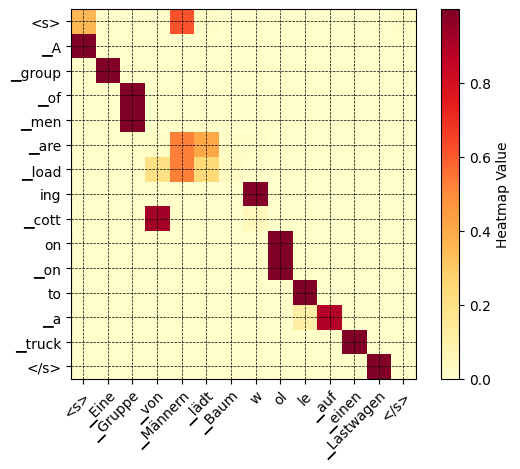

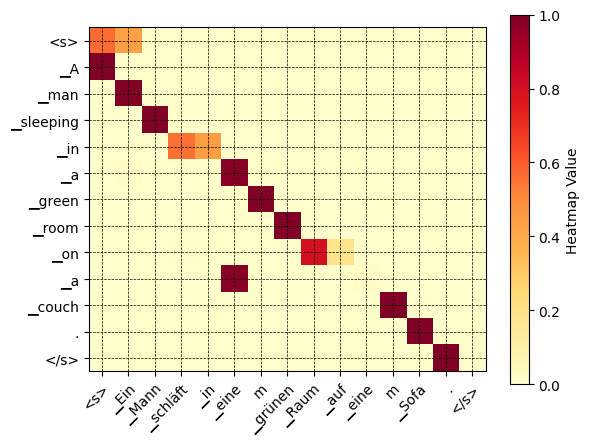

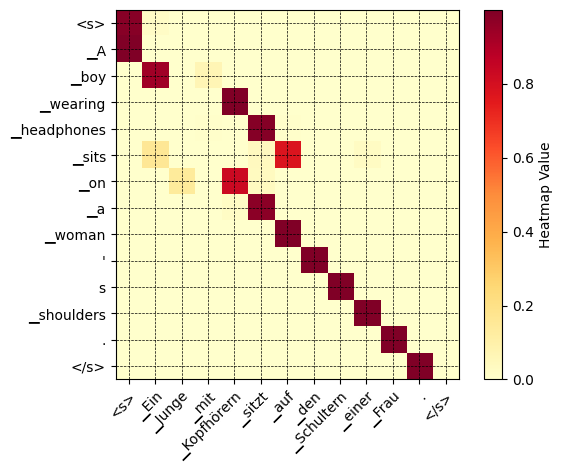

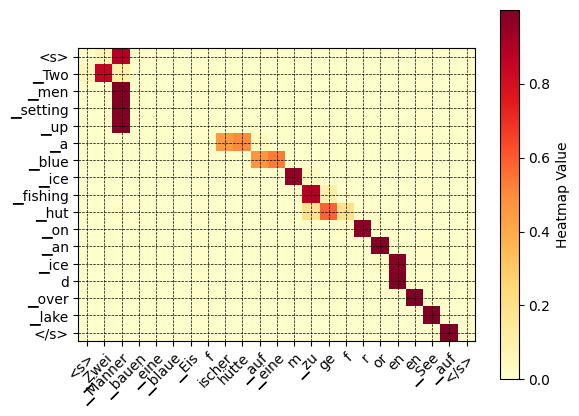

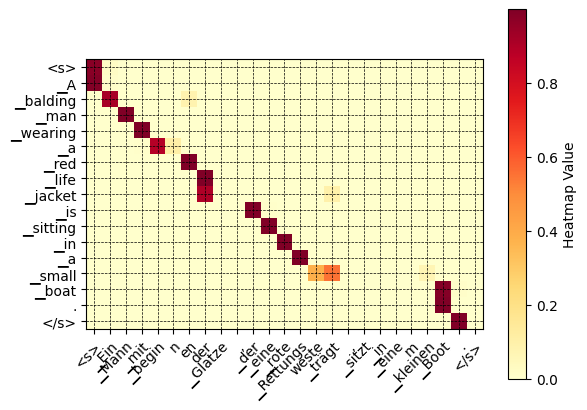

In [49]:
# You may find the following annotated heatmap tutorial helpful:
# https://matplotlib.org/3.1.3/gallery/images_contours_and_fields/image_annotated_heatmap.html.

# YOUR CODE HERE


# BEGIN SOLUTION
import matplotlib.pyplot as plt
import torch
attention_model = Seq2seqAttention().to(device)
attention_model.load_state_dict(torch.load("attention_model.pt"))

val_data=[(example.src,example.trg) for example in validation_data[:5]]

for dat in val_data:
    attention_model.eval()
    with torch.no_grad():
        encoder_output, encoder_mask, encoder_hidden = attention_model.encode(make_batch([dat[0]])) # src
        _, _, attention_weights = attention_model.decode(make_batch([dat[1]]), encoder_hidden, encoder_output, encoder_mask)
        # print(attention_weights.size())
        x = ['<s>']+vocab.EncodeAsPieces(dat[0])+['</s>']
        y = ['<s>']+vocab.EncodeAsPieces(dat[1])+['</s>']
        attention_weights=attention_weights.cpu()



        # Reshape 'heat' to a 2D tensor
        # print(attention_weights.size())
        # print(len(x),len(y))
        # attention_weights = attention_weights.view(len(x), len(y))
        attention_weights = np.array(attention_weights[:,0,:])
        attention_weights = np.flip(attention_weights, axis=(0, 1))
        # print(attention_weights.shape)

        # Create a figure and a subplot for the heatmap
        fig, ax = plt.subplots()
        im = ax.imshow(attention_weights, cmap="YlOrRd")  # You can choose a different colormap

        # Set the x and y labels
        ax.set_xticks(range(len(x)))
        ax.set_yticks(range(len(y)))
        ax.set_xticklabels(x)
        ax.set_yticklabels(y)

        # Rotate the x-axis labels for better readability (optional)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Add a colorbar
        cbar = ax.figure.colorbar(im, ax=ax, label="Heatmap Value")
        plt.grid(True, linestyle="--", linewidth=0.5, color="black")

        # Display the heatmap
        plt.show()
 





# END SOLUTION

\* Describe your findings in this text cell. \*


## Submission

Turn in the following files on Gradescope:
* hw2a.ipynb (IBM alignment notebook)
* example_alignments.pkl (generated from part 2a)
* multi20k_alignments.pkl (generated from part 2a)
* hw2b.ipynb (this notebook)
* predictions.json (the predictions file generated by running the cell below)
* report.pdf

Be sure to check the output of the autograder after it runs.  It should confirm that no files are missing and that the output files have the correct format.

The code below will generate the required predictions file.  **Note** that it is designed to create the file even if some required elements are missing so that you can submit for partial credit.  If you want full credit, you should check the output to make sure there are no warnings indicating missing portions.

In [23]:
# Run this cell to generate the predictions.json file required for submission.
baseline_model = Seq2seqBaseline().to(device)
baseline_model.load_state_dict(torch.load("baseline_model.pt"))
attention_model = Seq2seqAttention().to(device)
attention_model.load_state_dict(torch.load("attention_model.pt"))

def get_raw_predictions(model, dataset, method, batch_size=64):
  assert method in {"greedy", "beam"}
  source_sentences = [example.src for example in dataset]
  target_sentences = [example.trg for example in dataset]
  model.eval()
  predictions = []
  with torch.no_grad():
    for start_index in range(0, len(source_sentences), batch_size):
      if method == "greedy":
        prediction_batch = predict_greedy(
            model, source_sentences[start_index:start_index + batch_size])
      else:
        prediction_batch = predict_beam(
            model, source_sentences[start_index:start_index + batch_size])
      predictions.extend(prediction_batch)
  return predictions

def generate_predictions_file_for_submission(filepath):
  models = {"baseline": baseline_model, "attention": attention_model}
  datasets = {"validation": validation_data, "test": test_data}
  methods = ["greedy", "beam"]
  predictions = {}
  for model_name, model in models.items():
    for dataset_name, dataset in datasets.items():
      for method in methods:
        print(
            "Getting predictions for {} model on {} set using {} "
            "search...".format(model_name, dataset_name, method))
        if model_name not in predictions:
          predictions[model_name] = {}
        if dataset_name not in predictions[model_name]:
          predictions[model_name][dataset_name] = {}
        try:
          predictions[model_name][dataset_name][method] = get_raw_predictions(
              model, dataset, method)
        except:
          print("!!! WARNING: An exception was raised, setting predictions to None !!!")
          predictions[model_name][dataset_name][method] = None
  print("Writing predictions to {}...".format(filepath))
  with open(filepath, "w") as outfile:
    json.dump(predictions, outfile, indent=2)
  print("Finished writing predictions to {}.".format(filepath))

generate_predictions_file_for_submission("predictions.json")

Getting predictions for baseline model on validation set using greedy search...
Getting predictions for baseline model on validation set using beam search...


/home/slee/.conda/envs/cs288/lib/python3.7/site-packages/ipykernel_launcher.py:194: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/slee/.conda/envs/cs288/lib/python3.7/site-packages/ipykernel_launcher.py:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/slee/.conda/envs/cs288/lib/python3.7/site-packages/ipykernel_launcher.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/slee/.conda/envs/cs288/lib/python3.7/site-packages/ipykernel_launcher.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Getting predictions for baseline model on test set using greedy search...
Getting predictions for baseline model on test set using beam search...
Getting predictions for attention model on validation set using greedy search...
Getting predictions for attention model on validation set using beam search...
Getting predictions for attention model on test set using greedy search...
Getting predictions for attention model on test set using beam search...
Writing predictions to predictions.json...
Finished writing predictions to predictions.json.
